##### 공통부분

In [ ]:
# device 추가 필요
# 점수로 보자

In [12]:
# !pip install transformers nltk

# NLTK에서 문장 토큰화를 위한 도구 다운로드
# nltk.download('punkt')
import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')  # 구글 드라이브를 마운트

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# 변수
max_length = 512  # 모델의 최대 입력 길이

# 감정 분석 파이프라인 설정
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_model = pipeline("sentiment-analysis", model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [14]:
# 함수
# 1. 문단 전체로 감정 분석을 하는 경우
def analyze_paragraph(paragraph, max_length=max_length):
    """
    문단을 입력으로 받아, 최대 토큰 길이를 초과하는 경우 적절히 잘라서 감정 분석을 수행하는 함수.
    """
    # 입력이 None이거나 문자열이 아닐 경우 빈 문자열로 처리
    if not isinstance(paragraph, str):
        return "no data"

    sentences = sent_tokenize(paragraph)  # 문단을 문장으로 나눔
    sentiments = []

    for sentence in sentences:
        # 문장을 토큰화하여 max_length이상인 토큰은 max_length까지만 사용
        tokenized_sentence = tokenizer(sentence, return_length=True, truncation=True, max_length=max_length)
        truncated_sentence = tokenizer.decode(tokenized_sentence['input_ids'], skip_special_tokens=True)

        # 문장별로 감정 분석
        sentiment = sentiment_model(truncated_sentence)
        sentiments.append(sentiment[0]['label'])  # 여러 조각의 감정을 기록

    # 감정별 빈도수 계산
    sentiment_counts = {label: sentiments.count(label) for label in set(sentiments)}

    # 가장 빈도수가 높은 감정 선택
    most_common_sentiment = max(sentiment_counts, key=sentiment_counts.get)

    return sentiment_counts, most_common_sentiment

# 2. 문단에서 문장별로 감정 분석을 수행하는 경우
def analyze_paragraph_sentence_by_sentence(paragraph):
    sentences = sent_tokenize(paragraph)  # 문단을 문장 단위로 분리
    results = [sentiment_model(sentence) for sentence in sentences]  # 각 문장별 감정 분석
    return results


In [16]:
# 데이터 불러오기
annotated = pd.read_csv('/content/drive/MyDrive/Project_now/2024_아이펠톤/raw_data/Annotated_data.csv')
c2d2 = pd.read_csv('/content/drive/MyDrive/Project_now/2024_아이펠톤/raw_data/C2D2/C2D20911.csv')
meta = pd.read_csv('/content/drive/MyDrive/Project_now/2024_아이펠톤/raw_data/meta/meta0911.csv', encoding='latin1')

print(annotated.columns, c2d2.columns, meta.columns)

Index(['Id_Number', 'Patient Question', 'Distorted part',
       'Dominant Distortion', 'Secondary Distortion (Optional)'],
      dtype='object') Index(['Num', 'Scenario', 'Thought', 'Label'], dtype='object') Index(['persona', 'pattern', 'pattern_def', 'thought', 'scenario',
       'persona_in_scenario', 'thought_in_scenario'],
      dtype='object')


In [17]:
# 전처리
#
c2d2

##### 할 수 있는 분석
1. 클래스별 시각화 : 데이터셋별, class별, story/thought별 문단의 감정 분포 시각화
2. 감정 변화 패턴 분석 : 데이터셋별, class별, story/thought별 감점이 변하는 것 시각화

In [18]:
# 클래스별 시각화 : 데이터셋별, class별, story/thought별 문단의 감정 분포 시각화
annotated_01 = annotated.copy()
annotated_01['story_sentiment_counts'], annotated_01['story_most_common_sentiment'] = zip(*annotated_01['Patient Question'].apply(analyze_paragraph))
annotated_01['thought_sentiment_counts'], annotated_01['thought_most_common_sentiment'] = zip(*annotated_01['Distorted part'].apply(analyze_paragraph))

# c2d2_01 = c2d2.copy()
# c2d2_01['story_sentiment_counts'], c2d2_01['story_most_common_sentiment'] = zip(*c2d2_01['Patient Question'].apply(analyze_paragraph))
# c2d2_01['thought_sentiment_counts'], c2d2_01['thought_most_common_sentiment'] = zip(*c2d2_01['Distorted part'].apply(analyze_paragraph))

meta_01 = meta.copy()
meta_01['story_sentiment_counts'], meta_01['story_most_common_sentiment'] = zip(*meta_01['scenario'].apply(analyze_paragraph))
meta_01['thought_sentiment_counts'], meta_01['thought_most_common_sentiment'] = zip(*meta_01['thought'].apply(analyze_paragraph))

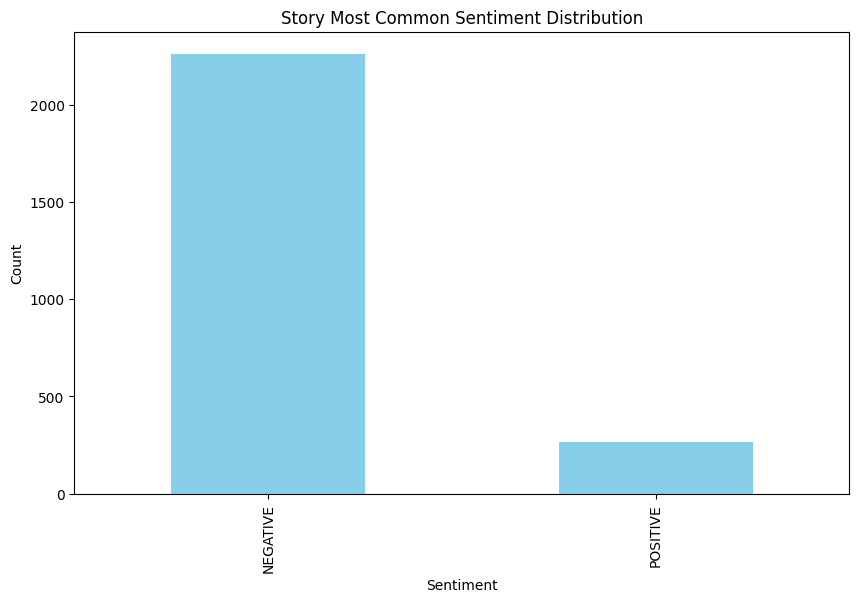

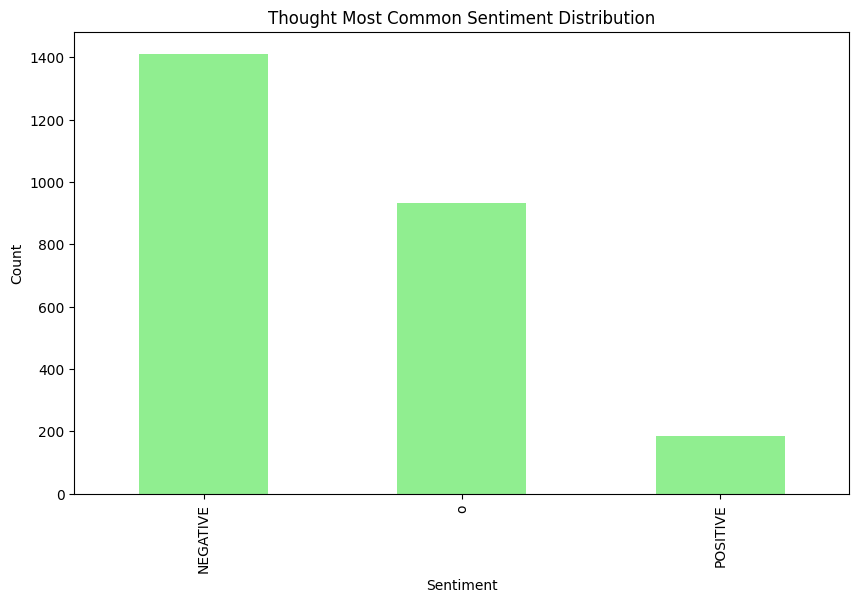

In [19]:
# 'story_most_common_sentiment'의 감정 분포 시각화
story_sentiment_counts = annotated_01['story_most_common_sentiment'].value_counts()

plt.figure(figsize=(10, 6))
story_sentiment_counts.plot(kind='bar', color='skyblue')
plt.title("Story Most Common Sentiment Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()

# 'thought_most_common_sentiment'의 감정 분포 시각화
thought_sentiment_counts = annotated_01['thought_most_common_sentiment'].value_counts()

plt.figure(figsize=(10, 6))
thought_sentiment_counts.plot(kind='bar', color='lightgreen')
plt.title("Thought Most Common Sentiment Distribution")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()

In [20]:
# 저장
# 데이터프레임을 CSV 파일로 저장
annotated_01.to_csv('/content/drive/MyDrive/Project_now/2024_아이펠톤/make_data/Annotated_data.csv', index=False)

print(f"데이터가 저장되었습니다.")


데이터가 저장되었습니다.
